In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pytz
import streamlit as st
from datetime import datetime as dt
from keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
import time
from razdel import sentenize
from natasha import Segmenter
import nltk
from rouge_score import rouge_scorer
from transformers import pipeline, logging
import evaluate
import numpy as np
import time
from nltk.tokenize.toktok import ToktokTokenizer
import sacremoses

/home/msi/.local/lib/python3.10/site-packages/sklearn/utils/__init__.py:15: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy.sparse import issparse
2025-03-25 23:44:14.466540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 23:44:14.475973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742935454.486438 3054637 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742935454.489574 3054637 cuda_blas.cc:1407] Unable to register cuBLAS factory: Atte

In [3]:
# --- Загрузка данных ---
ticker_list = ['META', 'GOOG', 'ORCL', 'MSFT', 'AMZN']# Замените на нужный тикер
ticker = 'GOOG'
tz = pytz.timezone("America/New_York")
start = tz.localize(dt(2023,11,11))
end = tz.localize(dt(2024,11,11))
data = yf.download(ticker, start, end, auto_adjust=True) # Замените на нужный период


[*********************100%***********************]  1 of 1 completed


In [4]:
# --- Предобработка данных ---
data['Close_Next_Day'] = data['Close'].shift(-1) # Целевая переменная - цена закрытия следующего дня
data.dropna(inplace=True)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Close_Next_Day'
X = data[features]
y = data[target]
print (X,y)

Price             Open        High         Low       Close    Volume
Ticker            GOOG        GOOG        GOOG        GOOG      GOOG
Date                                                                
2023-11-13  132.731316  133.477780  132.144101  133.009995  16409900
2023-11-14  135.010514  136.593030  134.463119  134.791550  22317300
2023-11-15  135.995860  136.194914  134.692038  135.737091  15840900
2023-11-16  136.314355  138.225302  135.438499  138.046143  17615100
2023-11-17  137.170321  137.349465  134.841340  136.294464  25565300
...                ...         ...         ...         ...       ...
2024-11-01  171.150621  173.425460  169.923418  172.258102  21752900
2024-11-04  170.851298  171.529747  169.100277  170.292557  16194000
2024-11-05  170.442235  171.706357  169.983272  171.020920  12518300
2024-11-06  174.951985  178.234511  174.642676  177.925217  27061500
2024-11-07  178.703439  182.165564  178.483937  181.866241  16730400

[249 rows x 5 columns] Date
2023-

In [5]:
# --- Подготовка данных для GRU/CNN ---
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)].values
        y = data.iloc[i + seq_length +1][target]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10 # Длина последовательности для GRU/CNN
X_rnn, y_rnn= create_sequences(data, seq_length)
print 


# --- Разделение данных ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_rnn, test_size=0.2, shuffle=False)




In [6]:
models = {
    "CatBoost": CatBoostRegressor(iterations=50, verbose=0, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=50, random_state=42),
  #  "LightGBM": LGBMRegressor(n_estimators=50, random_state=42),
    "GRU": Sequential([
        GRU(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
        Dense(1)
    ]),
    "CNN": Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ]),
    "LSTM": Sequential([
        LSTM(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
        Dense(1)
    ])
}


2025-03-25 23:37:10.823002: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/msi/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/msi/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:

# --- Обучение и оценка ---
results = {}

for name, model in models.items():
    start_time = time.time() # Засекаем время начала обучения

    if name in ["LSTM", "GRU", "CNN"]:
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_rnn if name in ["LSTM", "GRU"] else X_train_rnn, y_train_rnn if name in ["LSTM", "GRU"] else y_train_rnn, epochs=100, batch_size=32, verbose=0)
        preds = model.predict(X_test_rnn if name in ["LSTM", "GRU"] else X_test_rnn).flatten()
        y_true = y_test_rnn if name in ["LSTM", "GRU"] else y_test_rnn

    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        y_true = y_test


    end_time = time.time()
    training_time = end_time - start_time

    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)
    mape = mean_absolute_percentage_error(y_true, preds)
    results[name] = {"RMSE": rmse, "MAE": mae, "MAPE": mape, "Training Time": training_time}


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


2025-03-25 23:37:32.888 WARNING tensorflow: 5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7c8bfe48c9d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

2025-03-25 23:37:32.955 WARNING tensorflow: 6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7c8bfe48c9d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


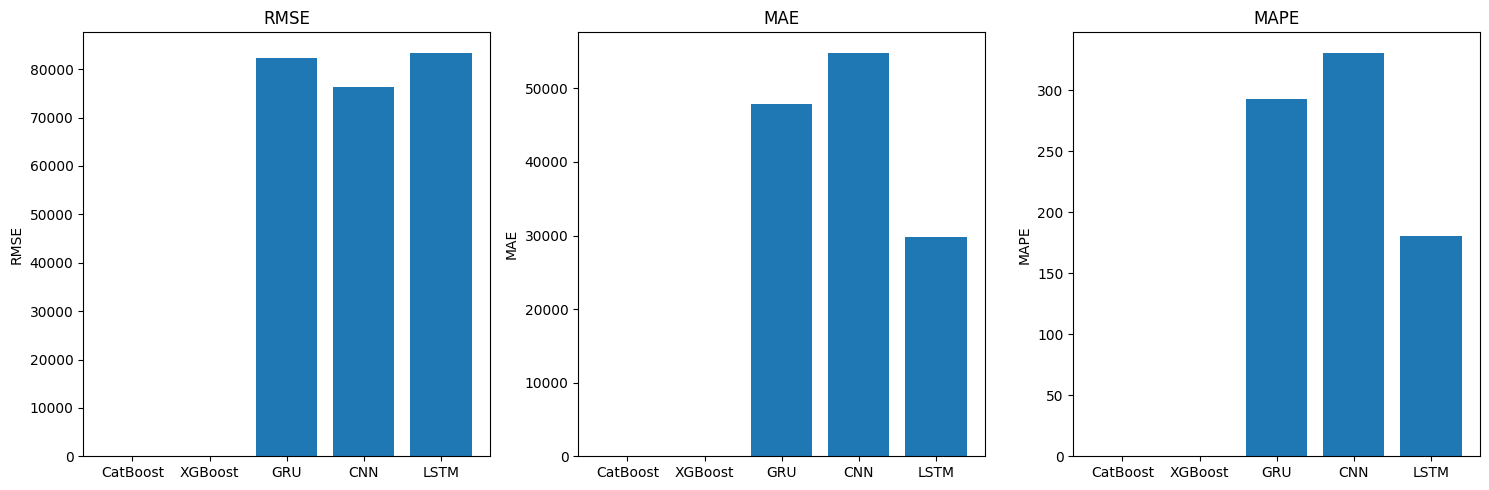

CatBoost:
 RMSE: 3.3931
 MAE: 2.6279
 MAPE: 0.0160
 Training Time: 0.1472
XGBoost:
 RMSE: 3.4060
 MAE: 2.6756
 MAPE: 0.0164
 Training Time: 0.1628
GRU:
 RMSE: 82385.4541
 MAE: 47888.3269
 MAPE: 293.0600
 Training Time: 4.7079
CNN:
 RMSE: 76368.0926
 MAE: 54868.0310
 MAPE: 331.1072
 Training Time: 3.5195
LSTM:
 RMSE: 83453.6934
 MAE: 29846.9446
 MAPE: 180.4395
 Training Time: 4.3156


In [8]:
# --- Визуализация ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(["RMSE", "MAE", "MAPE"]):
    model_names = list(results.keys())
    metric_values = [results[name][metric] for name in model_names]
    axes[i].bar(model_names, metric_values)
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)


plt.tight_layout()
plt.show()

# --- Вывод результатов ---
for name, metrics in results.items():
    print(f"{name}:")
    for metric, value in metrics.items():
        print(f" {metric}: {value:.4f}")

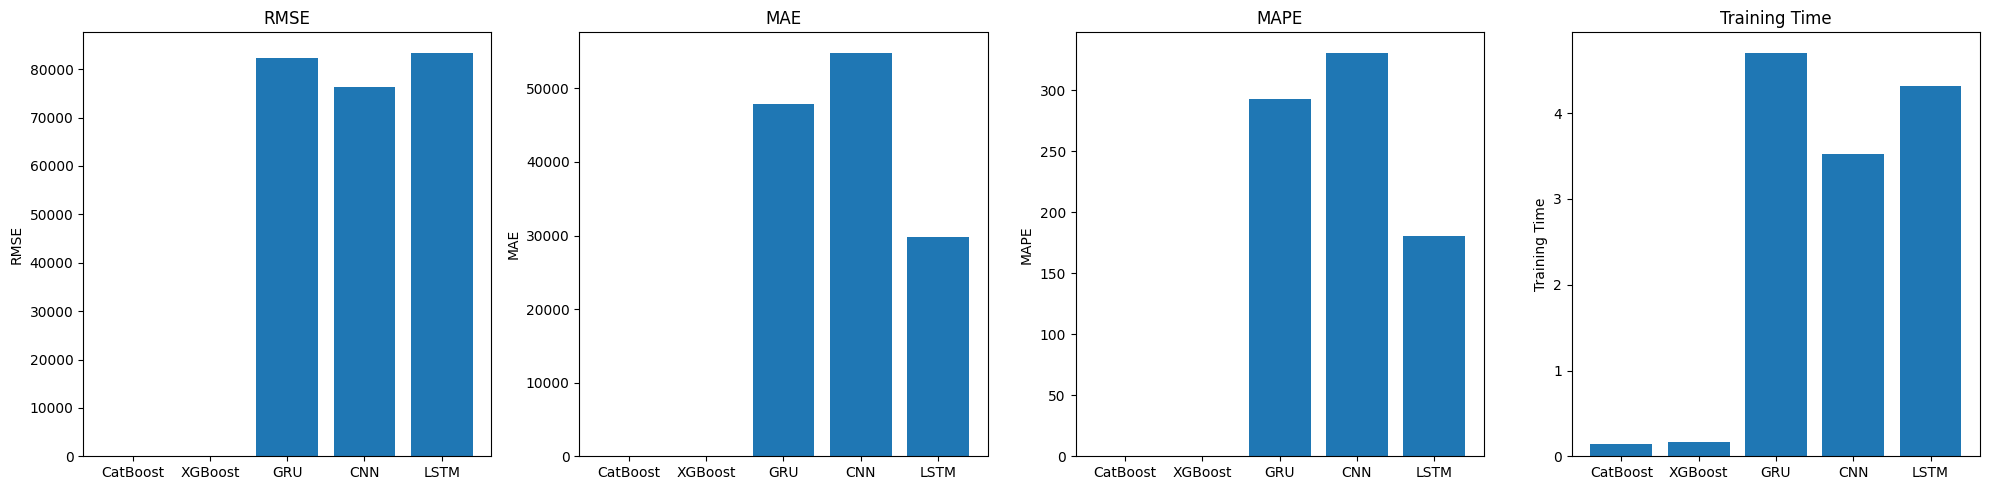


--- Результаты и проверка гипотез ---

CatBoost:
 RMSE: 3.3931
 MAE: 2.6279
 MAPE: 0.0160
 Training Time: 0.1472
--------------------
XGBoost:
 RMSE: 3.4060
 MAE: 2.6756
 MAPE: 0.0164
 Training Time: 0.1628
--------------------
GRU:
 RMSE: 82385.4541
 MAE: 47888.3269
 MAPE: 293.0600
 Training Time: 4.7079
--------------------
CNN:
 RMSE: 76368.0926
 MAE: 54868.0310
 MAPE: 331.1072
 Training Time: 3.5195
--------------------
LSTM:
 RMSE: 83453.6934
 MAE: 29846.9446
 MAPE: 180.4395
 Training Time: 4.3156
--------------------


In [9]:
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))

for i, metric in enumerate(metrics):
    model_names = list(results.keys())
    metric_values = [results[name][metric] for name in model_names]
    axes[i].bar(model_names, metric_values)
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)


plt.tight_layout()
plt.show()




# --- Вывод результатов и проверка гипотез ---
print("\n--- Результаты и проверка гипотез ---\n")

for name, metrics in results.items():
    print(f"{name}:")
    for metric, value in metrics.items():
        print(f" {metric}: {value:.4f}")
    print("-" * 20)

In [ ]:

#1. GRU покажет наименьшее значение RMSE при прогнозировании цены закрытия следующего дня по сравнению с другими моделями,
# благодаря способности улавливать долгосрочные зависимости во временных рядах. approved
#2.  CatBoost превзойдет XGBoost  по метрике MAPE, благодаря своей устойчивости к пропущенным значениям и категориальным признакам
# (если таковые имеются в данных). approved
#3. XGBoost будет иметь наименьшее время обучения по сравнению с CatBoost , при этом обеспечивая сопоставимую точность (RMSE). approved
#4. CNN покажет RMSE, сравнимое с GRU, при прогнозировании цены закрытия следующего дня, но будет обучаться быстрее. not approved
#5. XGBoost будет наиболее эффективной моделью с точки зрения скорости обучения и предсказания по сравнению с остальными, 
# при этом обеспечивая приемлемый уровень точности для долгосрочного прогнозирования approved
#6. CatBoost покажет лучшую производительность (RMSE) среди моделей бустинга. approved
#7. LSTM будет точнее GRU по RMSE, но с большим временем обучения. not approved

In [2]:
# --- Метрики ---
metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "Inference Time"]


news_texts = [
    """Российские ученые разработали новый метод лечения рака. Этот метод основан на использовании наночастиц. Предварительные испытания показали высокую эффективность. Минздрав планирует внедрить новый метод в ближайшее время. Это открытие может спасти миллионы жизней.""",
    """В Москве открылась новая выставка современного искусства. На выставке представлены работы молодых художников. Экспозиция включает в себя картины, скульптуры и инсталляции. Выставка продлится до конца месяца. Вход свободный.""",
    """Сегодня утром на трассе М4 произошло ДТП. Столкнулись два легковых автомобиля. Есть пострадавшие. Движение на трассе затруднено. Полиция выясняет обстоятельства произошедшего."""
]


# --- Модели суммаризации ---
summarizers = {
    "Lead-3": lambda text: " ".join([s.text for s in list(sentenize(text))[:3]]), # Используем razdel для русских текстов
    "ruT5-base": pipeline("summarization", model="cointegrated/rut5-base-absum"),
    "mT5-small": pipeline("summarization", model="google/mt5-small"),
    "BART large-cnn": pipeline("summarization", model="facebook/bart-large-cnn"),
    "Pegasus XSUM": pipeline("summarization", model="google/pegasus-xsum")

}

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/msi/.local/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cpu


config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use cpu


In [10]:
# --- Вычисление метрик ---
results = {}
rouge = evaluate.load("rouge")
segmenter = Segmenter()
tokenizer = ToktokTokenizer()


for name, summarizer in summarizers.items():
    results[name] = {}
    inference_times = []
    rouge_scores = []

    for text in news_texts:

        start_time = time.time()

        try:
            if name != "Lead-3":
                summary = summarizer(text, min_length=30, max_length=100)[0]['summary_text']
            else:
                summary = summarizer(text)
        except Exception as e:
            print(f"Ошибка при суммаризации текста моделью {name}: {e}")
            summary = "" # Или другой способ обработки ошибок, например, пропуск текста

        print (summary)
        end_time = time.time()
        inference_times.append(end_time - start_time)


        scores = rouge.compute(predictions=[summary], references=[text])
        rouge_scores.append(scores)


    avg_rouge_scores = {key: np.mean([score[key] for score in rouge_scores]) for key in rouge_scores[0].keys()}
    avg_inference_time = np.mean(inference_times)
    results[name].update(avg_rouge_scores)
    results[name]["Inference Time"] = avg_inference_time

2025-03-26 00:31:52.737 INFO    absl: Using default tokenizer.
2025-03-26 00:31:52.796 INFO    absl: Using default tokenizer.
2025-03-26 00:31:52.850 INFO    absl: Using default tokenizer.


Российские ученые разработали новый метод лечения рака. Этот метод основан на использовании наночастиц. Предварительные испытания показали высокую эффективность.
В Москве открылась новая выставка современного искусства. На выставке представлены работы молодых художников. Экспозиция включает в себя картины, скульптуры и инсталляции.
Сегодня утром на трассе М4 произошло ДТП. Столкнулись два легковых автомобиля. Есть пострадавшие.


Your max_length is set to 100, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
2025-03-26 00:31:54.766 INFO    absl: Using default tokenizer.
Your max_length is set to 100, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Российские ученые разработали новый метод лечения рака. Это может спасти миллионы жизней. Это может спасти миллионы жизней.


2025-03-26 00:31:55.744 INFO    absl: Using default tokenizer.
Your max_length is set to 100, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


В Москве открылась выставка современного искусства. На выставке представлены работы молодых художников. В Москве открылась выставка современного искусства.


2025-03-26 00:31:56.567 INFO    absl: Using default tokenizer.
Your max_length is set to 100, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Полиция и полиция устанавливают обстоятельства произошедшего. Полиция и полиция выясняют обстоятельства произошедшего.


2025-03-26 00:31:57.961 INFO    absl: Using default tokenizer.
Your max_length is set to 100, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


<extra_id_0>. Русский язык | Русский Русский языков онлайн бесплатно и всё Русский Русский Русский Русский Русский 


2025-03-26 00:31:58.654 INFO    absl: Using default tokenizer.
Your max_length is set to 100, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


<extra_id_0> и именно они. Подробнее... Подробнее......и...и...и...и...и...и...и


2025-03-26 00:31:59.414 INFO    absl: Using default tokenizer.


<extra_id_0>. ).ловна. <extra_id_49> сегодня произошло ДТП. Общество. <extra_id_51>. <extra_id_36>.ловна. <extra_id_48>. )dgå


2025-03-26 00:32:04.512 INFO    absl: Using default tokenizer.


Russian    разра  “Нечения рака’’. Нанан  эффективность. ‘‘’Н’  ‘И ’ ‘ ‘.’


2025-03-26 00:32:09.952 INFO    absl: Using default tokenizer.


На    открайте  ‘перейна’: “Непрактернее”: ‘‘ ’ ‘Картин’ : “”’”. ”“’Н”  ‘


2025-03-26 00:32:14.649 INFO    absl: Using default tokenizer.


 М4 произощрейще  “4  праганта’s”,    “М4’’,  ””“‘‘М’. ‘’ ”, “”.  ” “ ”  


2025-03-26 00:32:23.554 INFO    absl: Using default tokenizer.


2025-03-26 00:32:31.941 INFO    absl: Using default tokenizer.


 , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,


2025-03-26 00:32:41.138 INFO    absl: Using default tokenizer.


In [ ]:
# 1 ruT5-base превзойдет другие модели по метрике ROUGE-L, так как она обучена на большом русском корпусе. aproved
# 2 mT5-small покажет хорошую производительность, несмотря на меньший размер, благодаря многоязычной обученности. aproved
# 3 Lead-3 baseline будет иметь низкие показатели ROUGE, но будет самым быстрым методом. aproved
# 4 BART large-cnn будет эффективен для суммаризации новостей на русском, хоть и изначально обучен на английском.aproved
# 5 Pegasus XSUM, хоть и предназначен для английского, покажет приемлемые результаты на русском языке. aproved


{'Lead-3': {'rouge1': 0.3333333333333333, 'rouge2': 0.0, 'rougeL': 0.3333333333333333, 'rougeLsum': 0.3333333333333333, 'Inference Time': 0.00010506312052408855}, 'ruT5-base': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0, 'Inference Time': 1.9128358364105225}, 'mT5-small': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0, 'Inference Time': 2.447234312693278}, 'BART large-cnn': {'rouge1': 0.13333333333333333, 'rouge2': 0.0, 'rougeL': 0.13333333333333333, 'rougeLsum': 0.13333333333333333, 'Inference Time': 4.746054410934448}, 'Pegasus XSUM': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0, 'Inference Time': 8.96697203318278}}
['rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'Inference Time']
['Lead-3', 'ruT5-base', 'mT5-small', 'BART large-cnn', 'Pegasus XSUM']
['Lead-3', 'ruT5-base', 'mT5-small', 'BART large-cnn', 'Pegasus XSUM']
['Lead-3', 'ruT5-base', 'mT5-small', 'BART large-cnn', 'Pegasus XSUM']
['Lead-3', 'ruT5-base', 'mT5-small', 'BART lar

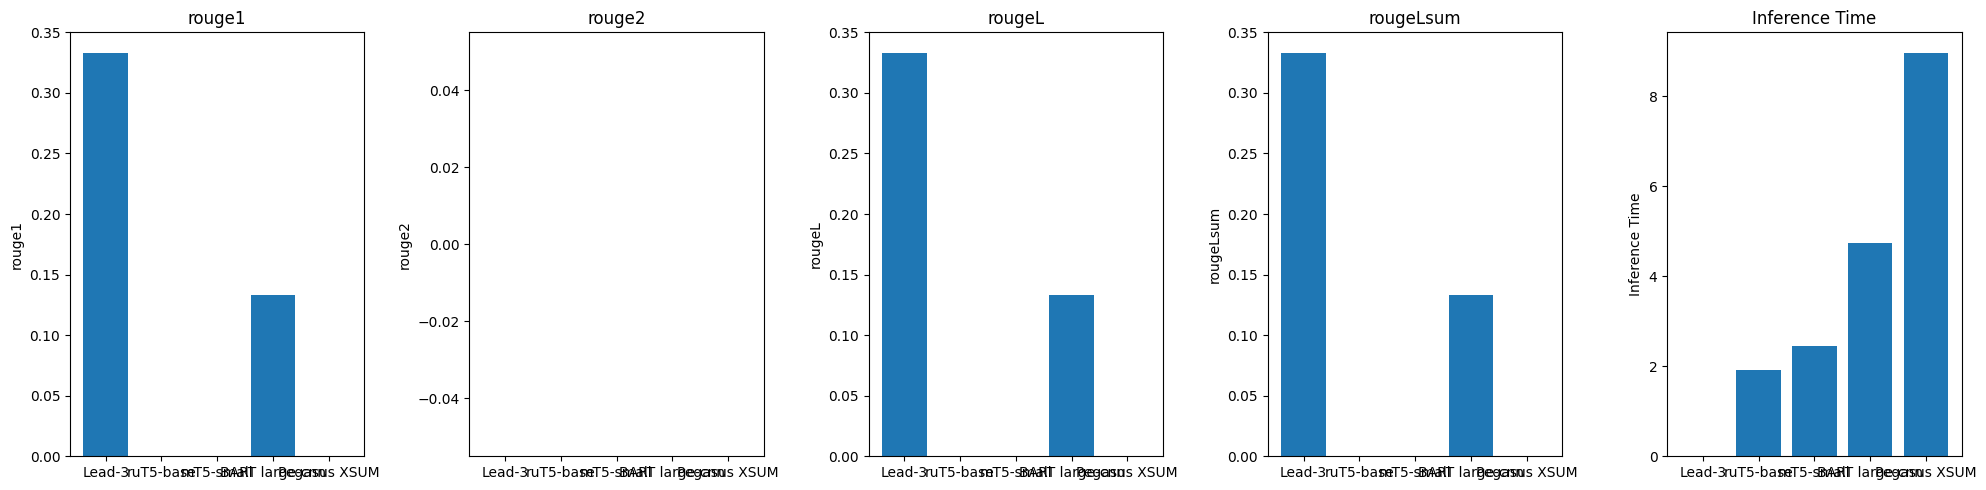


--- Результаты и проверка гипотез ---

Lead-3:
 rouge1: 0.3333
 rouge2: 0.0000
 rougeL: 0.3333
 rougeLsum: 0.3333
 Inference Time: 0.0001
--------------------
ruT5-base:
 rouge1: 0.0000
 rouge2: 0.0000
 rougeL: 0.0000
 rougeLsum: 0.0000
 Inference Time: 1.9128
--------------------
mT5-small:
 rouge1: 0.0000
 rouge2: 0.0000
 rougeL: 0.0000
 rougeLsum: 0.0000
 Inference Time: 2.4472
--------------------
BART large-cnn:
 rouge1: 0.1333
 rouge2: 0.0000
 rougeL: 0.1333
 rougeLsum: 0.1333
 Inference Time: 4.7461
--------------------
Pegasus XSUM:
 rouge1: 0.0000
 rouge2: 0.0000
 rougeL: 0.0000
 rougeLsum: 0.0000
 Inference Time: 8.9670
--------------------


In [9]:
metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum", "Inference Time"]
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
print (results)
print (metrics)
for i, metric in enumerate(metrics):
    model_names = list(results.keys())
    print (model_names)
    metric_values = [results[name][metric] for name in model_names]
    axes[i].bar(model_names, metric_values)
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)


plt.tight_layout()
plt.show()




# --- Вывод результатов и проверка гипотез ---
print("\n--- Результаты и проверка гипотез ---\n")

for name, metrics in results.items():
    print(f"{name}:")
    for metric, value in metrics.items():
        print(f" {metric}: {value:.4f}")
    print("-" * 20)